## Классификация MNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

Давайте обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В этом задании мы воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплайн обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку с первого занятия.

Мы настоятельно рекомендуем писать код «с нуля», лишь изредка подглядывая в готовые примеры, а не просто «копировать-вставлять». Это поможет вам в будущем.

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.60MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Text(0.5, 1.0, 'Image label: 6')

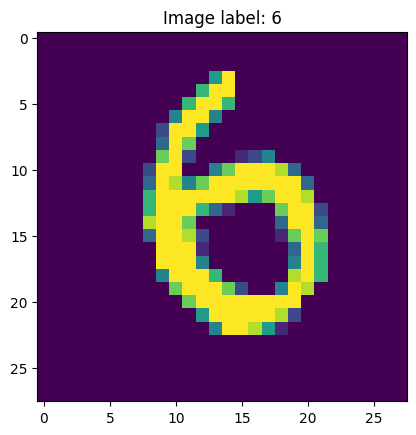

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель, представленную ниже. Пожалуйста, не создавайте чрезмерно сложную сеть — она не должна быть глубже четырёх слоёв (можно и меньше). Ваша основная задача — обучить модель и добиться как минимум 92% точности на тестовой выборке (hold-out выборке).

*Примечание: линейных слоёв и функций активации должно быть достаточно.*

__Обратите внимание, ваша модель должна быть представлена переменной `model`__

In [22]:
from typing import OrderedDict
# Creating model instance

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, activation, dropout_p, pool, i):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            (f'conv', nn.Conv2d(in_c, out_c, kernel_size, padding="same")),
            (f'bnorm', nn.BatchNorm2d(out_c)),
            (f'drop', nn.Dropout2d(dropout_p)),
            (f'act', activation),
        ]))
        self.pool = pool
        self.i = i
        if in_c != out_c and self.i:
            self.conv1 = nn.Conv2d(in_c, out_c, 1)
        else:
            self.conv1 = nn.Identity()

    def forward(self, x):
        if self.i:
            return self.pool(self.conv1(x) + self.block(x))
        else:
            return self.pool(self.block(x))

class MNISTModel(nn.Module):
    def __init__(
        self,
        input_size,
        num_conv_layers,
        kernel_sizes,
        hidden_size,
        activations,
        dropouts,
        poolings,
        output_size
    ):
        super().__init__()


        if not isinstance(kernel_sizes, list):
            kernel_sizes = [kernel_sizes] * num_conv_layers
        assert len(kernel_sizes) == num_conv_layers, f'provide {num_conv_layers} kernel_sizes or just one for all layers'

        assert isinstance(hidden_size, int), f'provide one hidden_size for all layers'
        hidden_sizes = [input_size[0]] + [hidden_size] * num_conv_layers

        if not isinstance(activations, list):
            activations = [activations] * num_conv_layers
        assert len(activations) == num_conv_layers, f'provide {num_conv_layers} activation functions or just one for all layers'

        if not isinstance(dropouts, list):
            dropouts = [dropouts] * num_conv_layers
        assert len(dropouts) == num_conv_layers, f'provide {num_conv_layers} dropout values or just one for all layers'

        if not isinstance(poolings, list):
            poolings = [poolings] * num_conv_layers
        assert len(poolings) == num_conv_layers, f'provide {num_conv_layers} poolings or just one for all layers'
        available_poolings = {None, nn.MaxPool2d, nn.AvgPool2d, nn.Identity}
        assert np.sum([poolings[i] in available_poolings for i in range(num_conv_layers)]) == num_conv_layers, \
               f'each pooling should be one of {available_poolings}'

        self.poolings = [poolings[i](2) if poolings[i] else nn.Identity() for i in range(num_conv_layers)]

        self.conv_block = nn.Sequential(OrderedDict([
            (f'conv0', nn.Conv2d(in_channels=input_size[0], out_channels=hidden_sizes[0], kernel_size=3)),
            (f'bn0', nn.BatchNorm2d(hidden_sizes[0])),
            (f'activ0', nn.LeakyReLU(0.2)),
        ]))
        self.layers = nn.Sequential(OrderedDict(
            [
                (f'block{i}', residual_block(
                    hidden_sizes[i],
                    hidden_sizes[i + 1],
                    kernel_sizes[i],
                    activations[i],
                    dropouts[i],
                    self.poolings[i],
                    i
                )) for i in range(num_conv_layers)
            ]
        ))
        self.head = nn.Sequential(OrderedDict([
            (f'flatten', nn.Flatten()),
            (f'hid2out', nn.Linear(hidden_sizes[-1] * 3 * 3, output_size)),
            (f'log_softmax', nn.LogSoftmax(dim=-1)),
        ]))
        # self.net = nn.Sequential(*[self.conv_block, self.layers, self.head])

    def forward(self, x):
        # return self.net(x)
        out = self.conv_block(x.view(-1, 1, 28, 28))
        out = self.layers(out)
        out = self.head(out)
        return out

In [23]:
classes = len(train_mnist_data.classes)
classes

10

In [24]:
img_size = train_mnist_data.data[0].unsqueeze(0).shape
img_size

torch.Size([1, 28, 28])

In [25]:
# Creating model instance
# model = None # your code here
model = MNISTModel(
    input_size = img_size,
    num_conv_layers = 3,
    kernel_sizes = 3,
    hidden_size = 32,
    activations = nn.LeakyReLU(0.2),
    dropouts = 0.2,
    poolings = nn.AvgPool2d,
    output_size = classes
)

Ниже доступны локальные тесты для проверки вашей модели:

In [26]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Обучите модель на обучающей выборке. Рекомендуем поэкспериментировать с различными оптимизаторами.


In [27]:
CUDA_DEVICE_ID = 0
device = ( torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu"))

In [28]:
import IPython
from math import ceil

def train_loop(model, dataloader, optim, loss_fn, scheduler=None, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)
    model.train()

    train_loss, train_acc = [], []

    size = len(dataloader.dataset)
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1

    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc='Batch #')):
        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = loss_fn(preds, y)
        train_loss.append(loss.item())
        acc = (preds.argmax(1) == y).type(torch.float).sum().item()
        train_acc.append(acc / y.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch == batches:
            out.update(f'[Acc: {np.mean(train_acc)} Loss: {np.mean(train_loss):>8f}')
    if scheduler:
        try:
            scheduler.step()
        except:
            scheduler.step(loss)

    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}

def eval_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):
    model.eval()

    val_loss, val_acc = [], []

    size = len(dataloader.dataset)
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1

    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc='Batch #')):
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            loss = loss_fn(preds, y)
            val_loss.append(loss.item())
            acc = (preds.argmax(1) == y).type(torch.float).sum().item()
            val_acc.append(acc / y.size(0))

    print(f"Validation accuracy: {(100*np.mean(val_acc)):>0.1f}%, Validation loss: {np.mean(val_loss):>8f} \n")

    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    if history_acc is not None:
        history_acc.append(np.mean(val_acc))

    return {'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc)}

In [29]:
def plot_learning_process(train_loss, train_acc, val_loss, val_acc):

    fig = plt.figure(figsize=(12, 4))

    ax1 = plt.subplot(121)
    ax1.set_title('loss by epoch')
    ax1.plot(np.arange(0, len(train_loss)) + 0.5, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss function')

    ax2 = plt.subplot(122)
    ax2.set_title('accuracy by epoch')
    ax2.plot(np.arange(0, len(train_acc)) + 0.5, train_acc, label='train')
    ax2.plot(np.arange(0, len(val_acc)) + 1, val_acc, label='val')
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')

    fig.tight_layout()
    plt.show()

Epoch 1
-------------------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


'[Acc: 0.9250333333333334 Loss: 0.256606'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 97.5%, Validation loss: 0.077610 

Epoch 2
-------------------------------


'[Acc: 0.9682166666666666 Loss: 0.102870'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 98.5%, Validation loss: 0.050173 

Epoch 3
-------------------------------


'[Acc: 0.9755166666666667 Loss: 0.080359'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 98.6%, Validation loss: 0.043047 

Epoch 4
-------------------------------


'[Acc: 0.9781833333333333 Loss: 0.069245'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 98.6%, Validation loss: 0.039996 

Epoch 5
-------------------------------


'[Acc: 0.9812166666666666 Loss: 0.061780'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 98.7%, Validation loss: 0.037961 

Epoch 6
-------------------------------


'[Acc: 0.9822666666666666 Loss: 0.057310'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.0%, Validation loss: 0.033772 

Epoch 7
-------------------------------


'[Acc: 0.98415 Loss: 0.052107'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.0%, Validation loss: 0.030201 

Epoch 8
-------------------------------


'[Acc: 0.9845333333333334 Loss: 0.050072'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.0%, Validation loss: 0.027618 

Epoch 9
-------------------------------


'[Acc: 0.9853 Loss: 0.047054'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.1%, Validation loss: 0.027183 

Epoch 10
-------------------------------


'[Acc: 0.9858666666666667 Loss: 0.045178'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.0%, Validation loss: 0.029147 

Epoch 11
-------------------------------


'[Acc: 0.9864333333333334 Loss: 0.043281'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.2%, Validation loss: 0.026874 

Epoch 12
-------------------------------


'[Acc: 0.9868333333333333 Loss: 0.041726'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.1%, Validation loss: 0.026133 

Epoch 13
-------------------------------


'[Acc: 0.9867666666666667 Loss: 0.040605'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.2%, Validation loss: 0.025557 

Epoch 14
-------------------------------


'[Acc: 0.9882333333333333 Loss: 0.037488'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.2%, Validation loss: 0.027139 

Epoch 15
-------------------------------


'[Acc: 0.9884333333333334 Loss: 0.036558'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 99.3%, Validation loss: 0.022815 



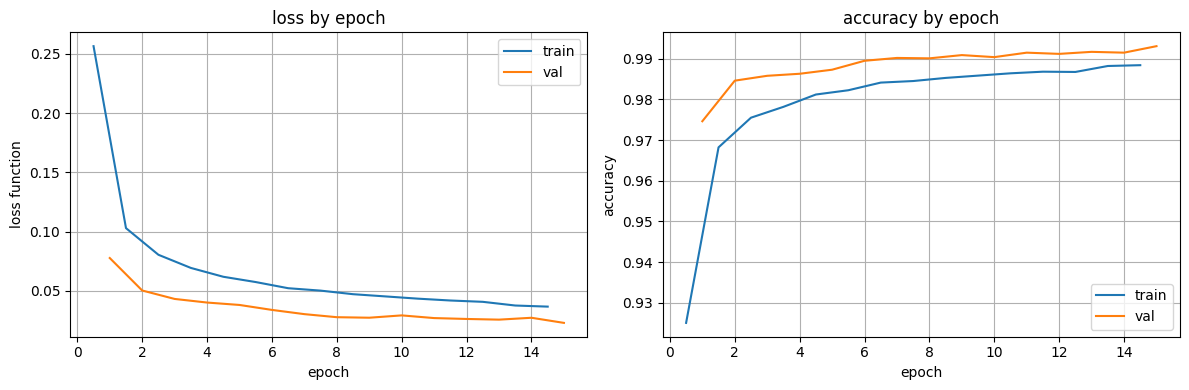

In [30]:
from tqdm.notebook import tqdm
model.to(device)
loss_fn = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), 1e-3, [0.9, 0.999])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=50,
    verbose=True,
)
epochs = 15

train_loss, train_acc, train_lr = [], [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(model, train_data_loader, optimizer, loss_fn, scheduler, history_loss=train_loss, history_acc=train_acc)
    eval_loop(model, test_data_loader, loss_fn, history_loss=val_loss, history_acc=val_acc)
    for param_group in optimizer.param_groups:
        train_lr.append(param_group['lr'])
plot_learning_process(train_loss, train_acc, val_loss, val_acc)

In [ ]:
# your code here

Также помните, что вы всегда можете обратиться к отличной [документации](https://pytorch.org/docs/stable/index.html) и [учебным материалам](https://pytorch.org/tutorials/).

Оценим качество классификации:

In [32]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        y_predicted = model(x.reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(y)

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [33]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.99375


In [35]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        y_predicted = model(x.reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(y)

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [36]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9931


Проверка, что пороги пройдены:

In [37]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model`, а файл `hw_mnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [40]:
with open('hw_mnist_data_dict.npy', 'rb') as f:
    header = f.read(8)
    print(header)

b'\x93NUMPY\x01\x00'


In [55]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('hw_mnist_data_dict.npy'), 'Please, download `hw_mnist_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784).to(device))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels).cpu().numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('hw_mnist_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_mnist_task_1.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_mnist_task_1.json`')
# __________end of block__________

File saved to `submission_dict_mnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_mnist_task_1.json` в задачу Warmup (hw_mnist)

На этом задание завершено. Поздравляем!